<a href="https://colab.research.google.com/github/ITProger123/handwriting-words-recognition/blob/main/Handwriting_word_recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import re
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import cv2
import os
import pandas as pd
from torchvision import transforms
from tqdm import tqdm
from torchinfo import summary

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
TRAIN_IMAGES_DIR = 'train_v2/train/'
VALID_IMAGES_DIR = 'validation_v2/validation/'
TEST_IMAGES_DIR = 'test_v2/test/'
TRAIN_CSV = 'written_name_train_v2.csv'
VALID_CSV = 'written_name_validation_v2.csv'
TEST_CSV = 'written_name_test_v2.csv'
IMAGE_SIZE = [64, 256]

In [4]:
DEVICE

'cuda'

In [ ]:
# Очистка набора данных
def get_dataset(csv_file):
    dataset = pd.read_csv(csv_file)
    cleaned_data = dataset.dropna()
    cleaned_data = cleaned_data[~cleaned_data['IDENTITY'].str.contains(' ')]
    cleaned_data['IDENTITY'] = cleaned_data['IDENTITY'].str.upper()
    cleaned_data = cleaned_data[cleaned_data['IDENTITY'].apply(lambda x: bool(re.match('^[A-Z]+$', x)))]
    return cleaned_data
train_data = get_dataset(TRAIN_CSV)
validation_data = get_dataset(VALID_CSV)
test_data = get_dataset(TEST_CSV)
vocablurary = "".join(list(set("".join(list(train_data['IDENTITY'])))))
print('Итоговый размер тренировочный данных:', train_data.shape[0])
print('Итоговый размер валидационный данных:', validation_data.shape[0])
print('Итоговый размер тестовых данных', test_data.shape[0])
print('Алфавит:', vocablurary)
print('Длина алфавита:', len(vocablurary))

Итоговый размер тренировочный данных: 315956
Итоговый размер валидационный данных: 39531
Итоговый размер тестовых данных 39429
Алфавит: JABPOTIZKVEWQSYNRUFDXHLGMC
Длина алфавита: 26


In [ ]:
CTC_BLANK = '<BLANK>'
# Создание карты кодирования букв
def get_char_map(alphabet):
	char_map = {value: idx + 1 for (idx, value) in enumerate(alphabet)}
	char_map[CTC_BLANK] = 0
	return char_map
# Создание класса, в котором будут проводиться необходимые преобразования
class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}
    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append([self.char_map[char] for char in word])
        return enc_words
    def get_num_chars(self):
        return len(self.char_map)
    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (char_enc != self.char_map[CTC_BLANK] and not (idx > 0 and char_enc == word[idx - 1])):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

In [ ]:
# Функция, которая перераспределяет порядок хранения данных в батче
def collate_fn(batch):
	images, texts, enc_texts = zip(*batch)
	images = torch.stack(images, 0)
	text_lens = torch.LongTensor([len(text) for text in texts])
	enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
	return images, texts, enc_pad_texts, text_lens
# Создание класса с набор данных, его экземпяры будут передаваться на вход моделе
class MyDataset(Dataset):
    def __init__(self, data_path, mode, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        if data_path == TRAIN_CSV:
            self.data = get_dataset(data_path)
        elif data_path == VALID_CSV:
            self.data = get_dataset(data_path)
        else:
            self.data = get_dataset(data_path)
        self.data_len = self.data.shape[0]
        self.img_paths = []
        self.texts = []
        for i, row in self.data.iterrows():
            self.img_paths.append(os.path.join(mode, row['FILENAME']))
            self.texts.append(row['IDENTITY'])
        self.enc_texts = tokenizer.encode(self.texts)
    def __len__(self):
        return self.data_len
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, text, enc_text

In [ ]:
# Параметры для приведения картинок к единому виду
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale()
    ]
)

In [ ]:
# Первая метрика - среднее пословное распознавание
def get_accuracy(y_true, y_pred):
	scores = []
	for true, pred in zip(y_true, y_pred):
		scores.append(true == pred)
	avg_score = np.mean(scores)
	return avg_score

# Вторая метрика - среднее побуквенное распознавание
def get_letter_accuracy(y_true, y_pred):
	scores = []
	for true, pred in zip(y_true, y_pred):
		cnt_pred_letter = 0
		cnt_true_letter = len(true)
		for letter_true, letter_pred in zip(list(true), list(pred)):
			if letter_true == letter_pred:
				cnt_pred_letter += 1
		scores.append(cnt_pred_letter/cnt_true_letter)
	avg_score = np.mean(scores)
	return avg_score

In [ ]:
# Создание классов моделей

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same')
        self.maxpool = nn.MaxPool2d((2, 2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        output = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        output = self.dropout(self.maxpool(self.relu(self.conv2(output))))
        output = self.maxpool(self.relu(self.bn3(self.conv3(output))))
        output = self.dropout(self.maxpool(self.relu(self.conv4(output))))
        return output

class BILSTM(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
		super().__init__()
		self.lstm = nn.LSTM(
		input_size, hidden_size, num_layers, dropout=dropout, batch_first=True,bidirectional=True)
	def forward(self, x):
		out, _ = self.lstm(x)
		return out
class CRNN(nn.Module):
    def __init__(self, number_class_symbols, time_feature_count=128, lstm_hidden=128, lstm_len=2):
        super().__init__()
        self.feature_extractor = CNN()
        self.avg_pool = nn.AdaptiveAvgPool2d((time_feature_count, time_feature_count))
        self.bilstm = BILSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(nn.Linear(lstm_hidden*2, time_feature_count), nn.GELU(),
                                        nn.Dropout(0.1), nn.Linear(time_feature_count, number_class_symbols))
    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w, = x.size()
        x = x.view(b, c*h, w)
        x=self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

In [ ]:
# Прогоняем тензор через модель, чтобы посмотреть на количество параметров и на корректность созданной арихитектуры
model = CRNN(27)
summary(model, (128, 1, 64, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [128, 128, 27]            --
├─CNN: 1-1                               [128, 256, 4, 16]         128
│    └─Conv2d: 2-1                       [128, 32, 64, 256]        320
│    └─BatchNorm2d: 2-2                  [128, 32, 64, 256]        64
│    └─ReLU: 2-3                         [128, 32, 64, 256]        --
│    └─MaxPool2d: 2-4                    [128, 32, 32, 128]        --
│    └─Conv2d: 2-5                       [128, 64, 32, 128]        18,496
│    └─ReLU: 2-6                         [128, 64, 32, 128]        --
│    └─MaxPool2d: 2-7                    [128, 64, 16, 64]         --
│    └─Dropout: 2-8                      [128, 64, 16, 64]         --
│    └─Conv2d: 2-9                       [128, 128, 16, 64]        73,856
│    └─BatchNorm2d: 2-10                 [128, 128, 16, 64]        256
│    └─ReLU: 2-11                        [128, 128, 16, 64]        --
│   

In [ ]:
train_accuracy = []
train_losss = []
val_accuracy = []
val_losss = []
lr_list = []

In [ ]:
# Инициализация данных для модели
vocablurary = 'IJOLTBMYSRGHFVUQAEXCNKWPZD'
tokenizer = Tokenizer(vocablurary)
train_data = MyDataset(TRAIN_CSV, TRAIN_IMAGES_DIR, tokenizer, transform=transform)
val_data = MyDataset(VALID_CSV, VALID_IMAGES_DIR, tokenizer, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
model = CRNN(number_class_symbols=tokenizer.get_num_chars())
model.to(DEVICE)
criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer=optimizer, mode='max', factor=0.1, patience = 5, threshold=0.03, threshold_mode='abs')
best_acc = -1

In [ ]:
# Запуск обучения
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loop = tqdm(train_loader)
    true_answers_train = []
    train_loss = []
    for images, texts, enc_pad_texts, text_lens in train_loop:
        images = images.to(DEVICE)
        enc_pad_texts = enc_pad_texts.to(DEVICE)
        text_lens = text_lens.to(DEVICE)
        output = model(images)
        output_lenghts = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)
        loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        mean_train_loss = sum(train_loss)/len(train_loss)
        pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
        text_preds = tokenizer.decode(pred)
        true_answer = get_letter_accuracy(texts, text_preds)
        true_answers_train.append(true_answer)
        train_loop.set_description(f"train_loss={mean_train_loss:.4f}")
    train_losss.append(mean_train_loss)
    model.eval()
    with torch.no_grad():
        val_loss = []
        val_loop = tqdm(val_loader)
        true_answers_val = []
        for images, texts, enc_pad_texts, text_lens in val_loop:
            images = images.to(DEVICE)
            enc_pad_texts = enc_pad_texts.to(DEVICE)
            text_lens = text_lens.to(DEVICE)
            output = model(images)
            output_lenghts = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)
            loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
            val_loss.append(loss.item())
            mean_val_loss = sum(val_loss)/len(val_loss)
            pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
            text_preds = tokenizer.decode(pred)
            true_answer = get_letter_accuracy(texts, text_preds)
            true_answers_val.append(true_answer)
        val_losss.append(mean_val_loss)
        mean_train_accuracy = sum(true_answers_train) / len(true_answers_train)
        mean_val_accuracy = sum(true_answers_val) / len(true_answers_val)
        train_accuracy.append(mean_train_accuracy)
        val_accuracy.append(mean_val_accuracy)
        if mean_val_accuracy > best_acc:
            best_acc = mean_val_accuracy
            checkpoint = {
                'state_model':model.state_dict(),
                'state_opt': optimizer.state_dict(),
                'state_lr_sheduler': scheduler.state_dict(),
                'loss': {
                    'train_loss':train_losss,
                    'val_loss':val_losss
                },
                'metric': {
                    'train_acc':train_accuracy,
                    'val_acc':val_accuracy,
                    'best_acc':best_acc
                },
                'lr': lr_list,
                'epoch': {
                    'EPOCHS':20,
                    'save_epoch':epoch+1
                }
            }
            torch.save(checkpoint, f'best_model_{epoch+1}.pt')
        scheduler.step(mean_val_accuracy)
        lr = scheduler._last_lr[0]
        lr_list.append(lr)
        print(f"Epoch {epoch+1}, train_loss={mean_train_loss:.4f}, train_acc={mean_train_accuracy:.6f}, val_loss={mean_val_loss:.4f}, val_acc={mean_val_accuracy:.6f}, lr={lr:.4f}")

100%|██████████| 309/309 [00:52<00:00,  5.84it/s]


Epoch 1, train_loss=3.1154, train_acc=0.045308, val_loss=2.7746, val_acc=0.048824, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.87it/s]


Epoch 2, train_loss=2.7405, train_acc=0.078574, val_loss=3.5274, val_acc=0.096924, lr=0.0010


100%|██████████| 309/309 [00:53<00:00,  5.76it/s]


Epoch 3, train_loss=1.9792, train_acc=0.339413, val_loss=1.4465, val_acc=0.503170, lr=0.0010


100%|██████████| 309/309 [00:53<00:00,  5.73it/s]


Epoch 4, train_loss=1.0174, train_acc=0.645692, val_loss=0.6909, val_acc=0.762186, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.84it/s]


Epoch 5, train_loss=0.6047, train_acc=0.791375, val_loss=0.4472, val_acc=0.848670, lr=0.0010


100%|██████████| 309/309 [00:55<00:00,  5.59it/s]


Epoch 6, train_loss=0.4508, train_acc=0.850984, val_loss=1.5782, val_acc=0.490259, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.91it/s]


Epoch 7, train_loss=0.3726, train_acc=0.882716, val_loss=0.2933, val_acc=0.910957, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.93it/s]


Epoch 8, train_loss=0.3291, train_acc=0.900734, val_loss=0.2831, val_acc=0.912043, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.89it/s]


Epoch 9, train_loss=0.3006, train_acc=0.911655, val_loss=0.2508, val_acc=0.931333, lr=0.0010


100%|██████████| 309/309 [00:52<00:00,  5.90it/s]

Epoch 10, train_loss=0.2789, train_acc=0.919865, val_loss=0.2946, val_acc=0.899331, lr=0.0010


Дообучение модели

In [ ]:
# Инициализация предобученных параметров модели
vocablurary = 'IJOLTBMYSRGHFVUQAEXCNKWPZD'
load_model_state = torch.load('best_model_10.pt', map_location=DEVICE)
tokenizer = Tokenizer(vocablurary)
train_data = MyDataset(TRAIN_CSV, TRAIN_IMAGES_DIR, tokenizer, transform=transform)
val_data = MyDataset(VALID_CSV, VALID_IMAGES_DIR, tokenizer, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
new_model = CRNN(number_class_symbols=tokenizer.get_num_chars()).to(DEVICE)
new_opt = torch.optim.AdamW(new_model.parameters(), lr=0.001, weight_decay=0.01)
new_sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=new_opt, mode='max', factor=0.1, patience = 5, threshold=0.03, threshold_mode='abs')
criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
new_model.load_state_dict(load_model_state['state_model'])
new_opt.load_state_dict(load_model_state['state_opt'])
new_sheduler.load_state_dict(load_model_state['state_lr_sheduler'])
NUM_EPOCHS = load_model_state['epoch']['EPOCHS']
save_epoch = load_model_state['epoch']['save_epoch']
train_losss = load_model_state['loss']['train_loss']
train_accuracy = load_model_state['metric']['train_acc']
val_losss = load_model_state['loss']['val_loss']
val_accuracy = load_model_state['metric']['val_acc']
lr_list = load_model_state['lr']
best_acc = load_model_state['metric']['best_acc']


In [ ]:
# Продолжаем обучение с последней записанной эпохи
for epoch in range(save_epoch+1, 21):
    new_model.train()
    train_loop = tqdm(train_loader)
    true_answers_train = []
    train_loss = []
    for images, texts, enc_pad_texts, text_lens in train_loop:
        images = images.to(DEVICE)
        enc_pad_texts = enc_pad_texts.to(DEVICE)
        text_lens = text_lens.to(DEVICE)
        output = new_model(images)
        output_lenghts = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)
        loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
        new_opt.zero_grad()
        loss.backward()
        new_opt.step()
        train_loss.append(loss.item())
        mean_train_loss = sum(train_loss)/len(train_loss)
        pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
        text_preds = tokenizer.decode(pred)
        true_answer = get_letter_accuracy(texts, text_preds)
        true_answers_train.append(true_answer)
        train_loop.set_description(f"train_loss={mean_train_loss:.4f}")
    train_losss.append(mean_train_loss)
    new_model.eval()
    with torch.no_grad():
        val_loss = []
        val_loop = tqdm(val_loader)
        true_answers_val = []
        for images, texts, enc_pad_texts, text_lens in val_loop:
            images = images.to(DEVICE)
            enc_pad_texts = enc_pad_texts.to(DEVICE)
            text_lens = text_lens.to(DEVICE)
            output = new_model(images)
            output_lenghts = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)
            loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
            val_loss.append(loss.item())
            mean_val_loss = sum(val_loss)/len(val_loss)
            pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
            text_preds = tokenizer.decode(pred)
            true_answer = get_letter_accuracy(texts, text_preds)
            true_answers_val.append(true_answer)
        val_losss.append(mean_val_loss)
        mean_train_accuracy = sum(true_answers_train) / len(true_answers_train)
        mean_val_accuracy = sum(true_answers_val) / len(true_answers_val)
        train_accuracy.append(mean_train_accuracy)
        val_accuracy.append(mean_val_accuracy)
        if mean_val_accuracy > best_acc:
            best_acc = mean_val_accuracy
            checkpoint = {
                'state_model':new_model.state_dict(),
                'state_opt': new_opt.state_dict(),
                'state_lr_sheduler': new_sheduler.state_dict(),
                'loss': {
                    'train_loss':train_losss,
                    'val_loss':val_losss
                },
                'metric': {
                    'train_acc':train_accuracy,
                    'val_acc':val_accuracy,
                    'best_acc':best_acc
                },
                'lr': lr_list,
                'epoch': {
                    'EPOCHS':40,
                    'save_epoch':epoch
                }
            }
            torch.save(checkpoint, f'best_model_{epoch}.pt')
        new_sheduler.step(mean_val_accuracy)
        lr = new_sheduler._last_lr[0]
        lr_list.append(lr)
        print(f"Epoch {epoch}, train_loss={mean_train_loss:.4f}, train_acc={mean_train_accuracy:.6f}, val_loss={mean_val_loss:.4f}, val_acc={mean_val_accuracy:.6f}, lr={lr}")

100%|██████████| 309/309 [00:55<00:00,  5.59it/s]


Epoch 10, train_loss=0.2798, train_acc=0.919301, val_loss=0.2493, val_acc=0.934105, lr=0.001


100%|██████████| 309/309 [00:53<00:00,  5.81it/s]


Epoch 11, train_loss=0.2650, train_acc=0.924736, val_loss=0.2379, val_acc=0.933734, lr=0.001


100%|██████████| 309/309 [00:51<00:00,  5.95it/s]


Epoch 12, train_loss=0.2523, train_acc=0.929015, val_loss=0.2262, val_acc=0.936853, lr=0.001


100%|██████████| 309/309 [00:54<00:00,  5.71it/s]


Epoch 13, train_loss=0.2448, train_acc=0.931365, val_loss=0.2485, val_acc=0.925248, lr=0.001


100%|██████████| 309/309 [00:53<00:00,  5.78it/s]


Epoch 14, train_loss=0.2356, train_acc=0.934402, val_loss=2.1376, val_acc=0.325475, lr=0.0001


100%|██████████| 309/309 [00:54<00:00,  5.68it/s]


Epoch 15, train_loss=0.2092, train_acc=0.942329, val_loss=0.1928, val_acc=0.951195, lr=0.0001


100%|██████████| 309/309 [00:53<00:00,  5.76it/s]


Epoch 16, train_loss=0.1967, train_acc=0.946010, val_loss=0.1908, val_acc=0.952670, lr=0.0001


100%|██████████| 309/309 [00:53<00:00,  5.74it/s]


Epoch 17, train_loss=0.1940, train_acc=0.946665, val_loss=0.1889, val_acc=0.953337, lr=0.0001


100%|██████████| 309/309 [00:53<00:00,  5.73it/s]


Epoch 18, train_loss=0.1909, train_acc=0.947595, val_loss=0.1878, val_acc=0.953191, lr=0.0001


100%|██████████| 309/309 [00:53<00:00,  5.74it/s]


Epoch 19, train_loss=0.1892, train_acc=0.947885, val_loss=0.1882, val_acc=0.953707, lr=0.0001


100%|██████████| 309/309 [00:54<00:00,  5.64it/s]

Epoch 20, train_loss=0.1877, train_acc=0.948405, val_loss=0.1862, val_acc=0.953366, lr=0.0001


In [ ]:
# Тест лучшей модели
load_model_state = torch.load('best_model_19.pt', map_location=DEVICE)
best_model = CRNN(number_class_symbols=tokenizer.get_num_chars()).to(DEVICE)
best_model.load_state_dict(load_model_state['state_model'])
train_losss = load_model_state['loss']['train_loss']
train_accuracy = load_model_state['metric']['train_acc']
val_losss = load_model_state['loss']['val_loss']
val_accuracy = load_model_state['metric']['val_acc']
lr_list = load_model_state['lr']

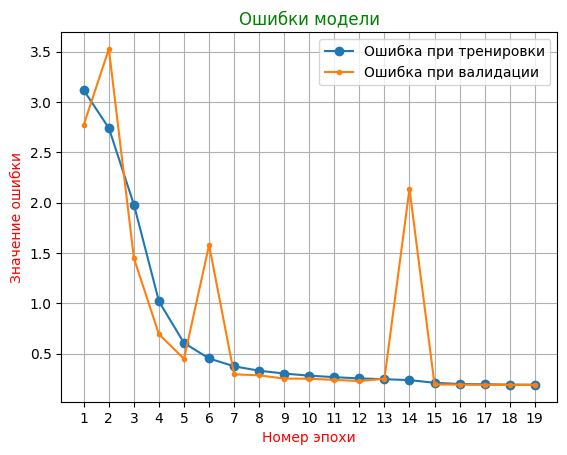

In [ ]:
x = list(range(1, 20))
plt.plot(x, train_losss, marker='o', label='Ошибка при тренировки')
plt.plot(x, val_losss, marker='.', label = 'Ошибка при валидации')
plt.grid()
plt.legend()
plt.title("Ошибки модели", color='green')
plt.xlabel('Номер эпохи', color='r')
plt.ylabel('Значение ошибки', color='r')
plt.xticks(list(range(1, 20)));

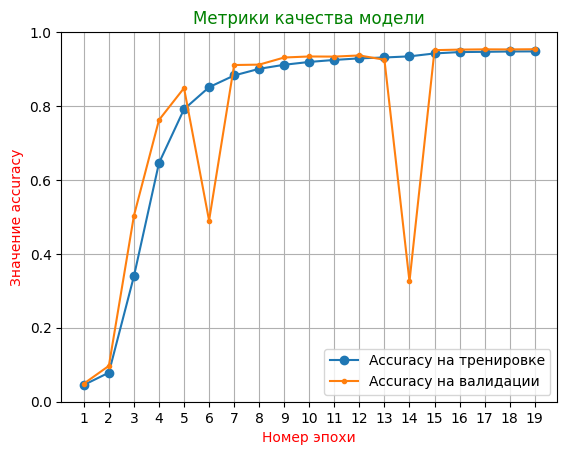

In [ ]:
x = list(range(1, 20))
plt.plot(x, train_accuracy, marker='o', label='Accuracy на тренировке')
plt.plot(x, val_accuracy, marker='.', label = 'Accuracy на валидации')
plt.grid()
plt.legend()
plt.title("Метрики качества модели", color='green')
plt.xlabel('Номер эпохи', color='r')
plt.ylabel('Значение accuracy', color='r')
plt.yticks(list(np.arange(0, 1.2, 0.2)));
plt.xticks(list(range(1, 20)));

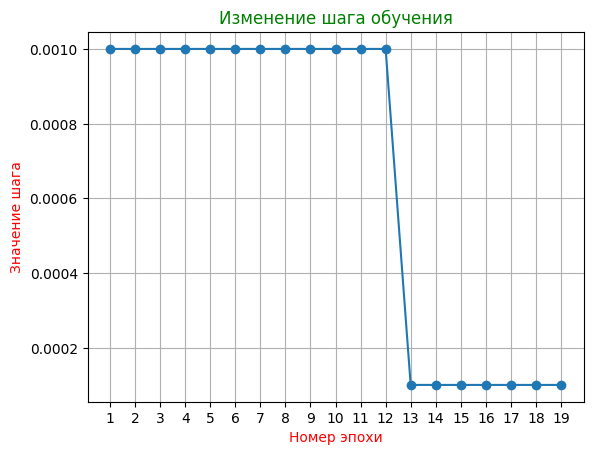

In [ ]:
x = list(range(1, 20))
plt.plot(x, lr_list, marker='o')
plt.grid()
plt.title("Изменение шага обучения", color='green')
plt.xlabel('Номер эпохи', color='r')
plt.ylabel('Значение шага', color='r')
plt.xticks(list(range(1, 20)));

In [ ]:
test_dataset = MyDataset(TEST_CSV, TEST_IMAGES_DIR, tokenizer, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_letter_score = []
test_val_score = []
test_loop = tqdm(test_loader)
best_model.eval()
tokenizer = Tokenizer('IJOLTBMYSRGHFVUQAEXCNKWPZD')
for images, texts, enc_pad_texts, text_lens in test_loop:
    images = images.to(DEVICE)
    output = best_model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    test_letter_score.append(get_letter_accuracy(texts, text_preds))
    test_val_score.append(get_accuracy(texts, text_preds))

100%|██████████| 309/309 [25:11<00:00,  4.89s/it]


In [ ]:
letter_score = sum(test_letter_score)/len(test_letter_score)
word_score = sum(test_val_score)/len(test_val_score)
print(f'Доля буквенного распознавания: {letter_score}')
print(f'Доля пословного распознавания: {word_score}')

Доля буквенного распознавания: 0.9524380323193608
Доля пословного распознавания: 0.8497269417475729


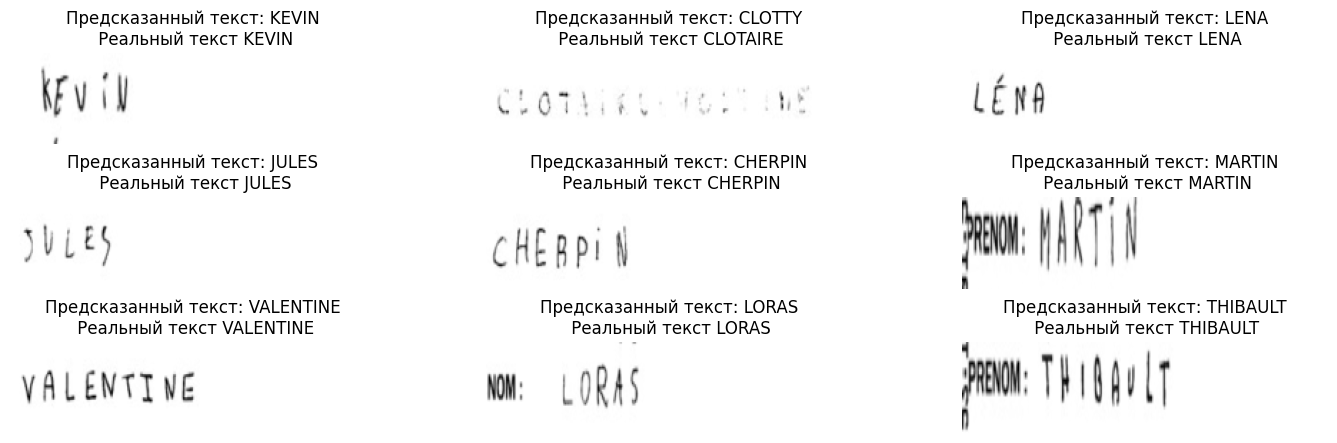

In [ ]:
# Предсказания модели на тестовой выборке
images, texts, _, _ = next(iter(test_loader))
plt.figure(figsize=(17, 10))
for index, (image, text) in enumerate(zip(images, texts)):
    plt.subplot(3, 3, index+1)
    new_image = image.unsqueeze(0)
    out = best_model(new_image)
    pred = torch.argmax(out.detach().cpu(), -1).permute(1, 0).numpy()
    text_pred = tokenizer.decode(pred)
    plt.title(f'Предсказанный текст: {text_pred[0]}\n Реальный текст {text}')
    image = image.permute(1, 2, 0)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if index > 7:
        break
plt.subplots_adjust(wspace=0.3, hspace=-0.7)
